In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nivapy
import seaborn as sn
import os
import lmfit
import emcee
import corner
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
sn.set_context('notebook')

# Flexible regression approaches

This notebook explores some tools for flexible non-linear regression. To begin with, we compare three different approaches for the simplest case of OLS linear regression with a single explanatory variable.

## 1. Generate "fake" regression data

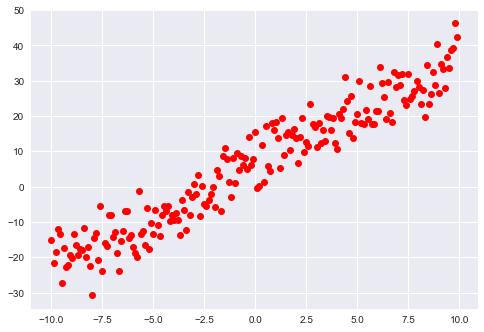

In [2]:
# y = mx + c + N(0, s)
m_true = 3
c_true = 6
s_true = 5
x = np.arange(-10, 10, 0.1)

# Data
np.random.seed(0) # Repeatability
y = m_true*x + c_true + np.random.normal(scale=s_true, size=len(x))

# Dataframe
df = pd.DataFrame({'x':x, 'y':y})

# Plot
plt.plot(x, y, 'ro')

## 2. Classic OLS regression

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     2213.
Date:                Tue, 28 Nov 2017   Prob (F-statistic):          2.02e-109
Time:                        14:45:03   Log-Likelihood:                -609.63
No. Observations:                 200   AIC:                             1223.
Df Residuals:                     198   BIC:                             1230.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.3522      0.362     17.526      0.0

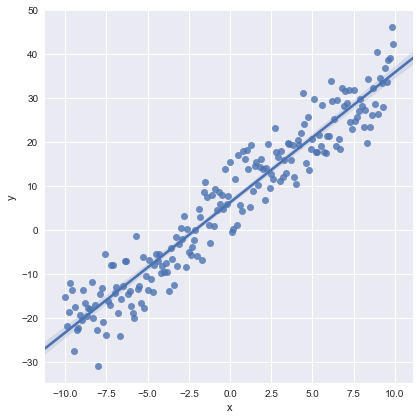

In [3]:
# OLS regression
mod_str = 'y ~ x'
model = smf.ols(mod_str, data=df)
result = model.fit()
print result.summary()

# Plot
sn.lmplot(x='x', y='y', data=df, ci=95, size=6)

Note that the CI shaded on this plot represents uncertainty in the deterministic parameters ***only*** (i.e. m and c, not sigma). To get the ***predictive uncertainty*** (i.e. including sigma), see the code [here](http://nbviewer.jupyter.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/07_GLUE.ipynb#2.-Frequentist-linear-regression).

## 2. Using LMFit

With LMFit, we can fit the parameters (in a least squares sense) simply by defining a function that returns the residuals (model - data). 

If we know beforehand the errors in each measurement (i.e. if you have a fixed array representing sigma for each data point), this function should return (model - data) / sigma instead (see [here](https://lmfit.github.io/lmfit-py/intro.html)).

**Note:** For complicated functions, the `Minimizer` will sometimes complain about NaN values. In this case, using the kwarg `nan_policy='omit'` may help.

In [4]:
def residual(params, x, y):
    """ Linear model.
    """
    v = params.valuesdict()
    model = v['m']*x + v['c']
    
    return (model - y)

# Create a set of Parameters
params = lmfit.Parameters()
params.add('m', value=2)
params.add('c', value=1)

# Fit
mi = lmfit.Minimizer(residual, params, fcn_args=(x, y))
result = mi.minimize()

# Calculate final result
final = result.residual + y # Residual was (model - y), so this is an
                            # easy way of getting back to 'model'

# Robustly estimate CI
ci = lmfit.conf_interval(mi, result, sigmas=[0.95,])

# Report
lmfit.report_fit(result)
print '\n--------------------------\n'
lmfit.printfuncs.report_ci(ci)

[[Fit Statistics]]
    # function evals   = 8
    # data points      = 200
    # variables        = 2
    chi-square         = 5201.838
    reduced chi-square = 26.272
    Akaike info crit   = 655.690
    Bayesian info crit = 662.287
[[Variables]]
    m:   2.95306642 +/- 0.062776 (2.13%) (init= 2)
    c:   6.35220588 +/- 0.362449 (5.71%) (init= 1)

--------------------------

      95.00%    _BEST_    95.00%
 m:  -0.12376   2.95307  +0.12376
 c:  -0.71476   6.35221  +0.71476


These results are identical to those above. It's actually easier to see this by printing the `ci` object itself, because this conatins absolute values for the upper and lower confidence bounds, rather than +/- notation, as above.

In [5]:
print ci['m']
print ''
print ci['c']

[(0.95, 2.8293040837834997), (0.0, 2.9530664262394124), (0.95, 3.0768287686889795)]

[(0.95, 5.637445601724498), (0.0, 6.3522058813295113), (0.95, 7.066965972544722)]


It is possible to develop this code to get predictive intervals (see [here](https://groups.google.com/forum/#!topic/lmfit-py/Ds-f-AVXG_E) for a start), but it's probably easier to go straight for MCMC if that's what you need.

Note that the above approach with LMFit can be appllied to **any** model (not just linear ones). This could include e.g. catchment hydrology models. Note also that there are lots of methods available in the `minimize` function, including things like `differential_evolution`, which are pretty good at finding global minima - see [here](https://lmfit.github.io/lmfit-py/fitting.html#the-minimize-function) for more details.

## 3. LMFit with emcee

LMFit also provides an interface to emcee. There are several ways to use this:

 * The most rigorous is to define the log-prior, log-likelihood and log-poisterior functions as usual, then just use LMFit's `Parameters` class and `minimizer.emcee` as conventient ways of accessing emcee. <br><br>
 
 * Alternatively, if you're happy using improper, uniform priors, you can use the `Parameters` class to define `min` and `max` values for each parameter and then just provide a log-likelihood function. This is obviously less rigorous, but often practically useful. <br><br>
 
 * Furthermore, if you're happy to assume i.i.d. Gaussian errors, you can combine the `residual` function from the standard LMFit approach with your log-likelihood, so you can use the other `minimizers` in LMFit to e.g. find the MAP.
 
The example below uses the simplest setup: uniform priors and i.i.d. Gaussian errors, which is equivalent to OLS. For an explanation of the formula in `lnprob()` and it's relationship to `residual()`, see [this notebook](http://nbviewer.jupyter.org/github/JamesSample/enviro_mod_notes/blob/master/notebooks/02_Calibration_Likelihood.ipynb#2.2.-Log-likelihood).

In [6]:
def lnprob(params, x, y):
    """ Log-likelihood for simple Gaussian error structure. Because
        we're using uniform (improper) priors, this is also the
        log-posterior.
    """
    # Unpack sigma
    sigma = params['s'].value
    
    # Log-likelihood
    ll = -0.5*np.sum((residual(params, x, y) / sigma)**2 + 
                     np.log(2*np.pi*sigma**2))
    
    return ll

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000D06A978>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000DF79A58>], dtype=object)

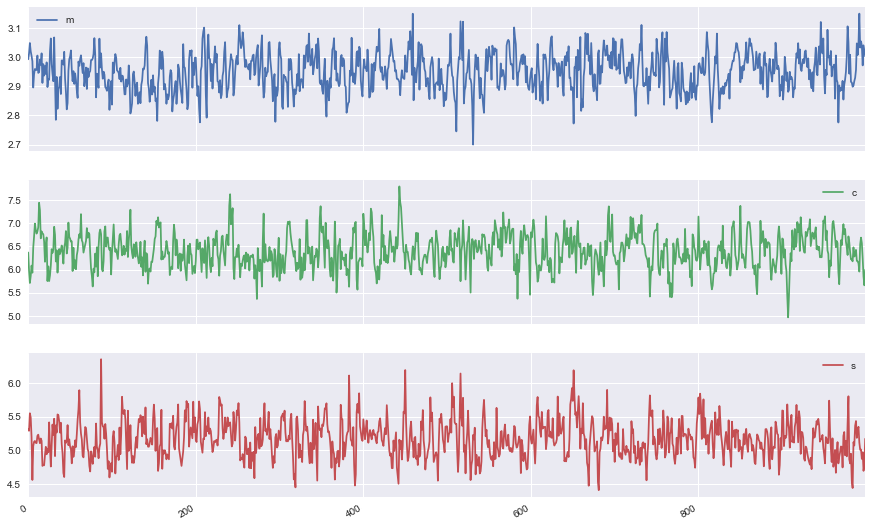

In [7]:
# We want to include sigma as an additional parameter in the MCMC
# Start from 'best fit' params found above
mi.params.add('s', value=1, min=1E-10)

# Run emcee sampler
mi_mcmc = lmfit.Minimizer(lnprob, mi.params, fcn_args=(x, y)) # Use 'best fit' params
result = mi_mcmc.emcee(burn=800, 
                       steps=1000, 
                       nwalkers=50, 
                       thin=10, 
                       params=mi.params, 
                       float_behavior='posterior') # lnprob returns a float representing log-posterior prob

# Plot traces
result.flatchain.plot(subplots=True, figsize=(15, 10))

Quantiles:
[(0.025, 2.8232306169387971), (0.5, 2.9530242589956388), (0.975, 3.0739134823893668)]
Quantiles:
[(0.025, 5.6858086573077591), (0.5, 6.3988323709887744), (0.975, 7.137922008976294)]
Quantiles:
[(0.025, 4.6618856111571407), (0.5, 5.1593123048396459), (0.975, 5.7505961311732285)]


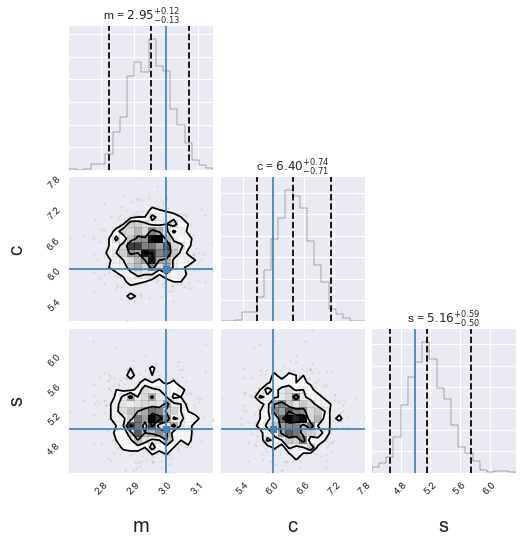

In [8]:
# Triangle plot
tri = corner.corner(result.flatchain,
                    labels=result.var_names,
                    truths=[m_true, c_true, s_true],
                    quantiles=[0.025, 0.5, 0.975],
                    show_titles=True, 
                    title_args={'fontsize': 24},
                    label_kwargs={'fontsize': 20},
                    verbose=True)

## 4. Non-linear example

This example is taken from [here](https://lmfit.github.io/lmfit-py/fitting.html#minimizer-emcee-calculating-the-posterior-probability-distribution-of-parameters). Getting sensible CIs for this double exponential function is generally considered to be quite a difficult problem (see [here](https://lmfit.github.io/lmfit-py/confidence.html#an-advanced-example)).

### 4.1. Generate data

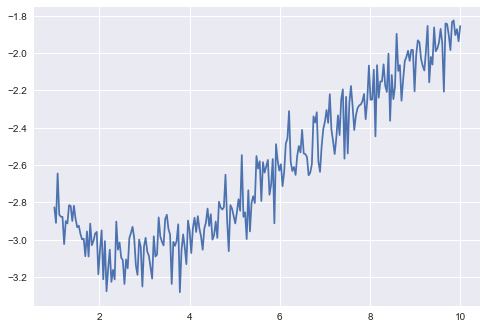

In [9]:
# Fake data
a1_true = 3.
t1_true = 2.
a2_true = -5.
t2_true = 10.
s_true = 0.1
x = np.linspace(1, 10, 250)

# Data
y = a1_true*np.exp(-x / t1_true) + a2_true*np.exp(-(x - 0.1) / t2_true) 
y += np.random.normal(scale=s_true, size=len(x))

# Plot
plt.plot(x, y)

### 4.2. Least squares fitting

C:\Data\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: overflow encountered in exp
C:\Data\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: overflow encountered in multiply
C:\Data\Anaconda2\lib\site-packages\lmfit\minimizer.py:157: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()


[[Fit Statistics]]
    # function evals   = 8
    # data points      = 250
    # variables        = 4
    chi-square         = 2.539
    reduced chi-square = 0.010
    Akaike info crit   = -1139.456
    Bayesian info crit = -1125.370
[[Variables]]
    a1:   2.71315393 +/- 0.207689 (7.65%) (init= 2.713139)
    t1:   1.89420312 +/- 0.279569 (14.76%) (init= 1.894187)
    a2:  -4.77327775 +/- 0.297951 (6.24%) (init=-4.773257)
    t2:   10.6374277 +/- 0.730433 (6.87%) (init= 10.63748)
[[Correlations]] (unreported correlations are <  0.100)
    C(a2, t2)                    =  0.994 
    C(t1, a2)                    = -0.970 
    C(t1, t2)                    = -0.946 
    C(a1, t2)                    = -0.920 
    C(a1, a2)                    = -0.899 
    C(a1, t1)                    =  0.775 

--------------------------

       95.00%    _BEST_    95.00%
 a1:  -0.31007   2.71315  +0.86536
 t1:  -0.43658   1.89420  +0.76331
 a2:  -1.05866  -4.77328  +0.41399
 t2:  -1.71529  10.63743  +1.2790

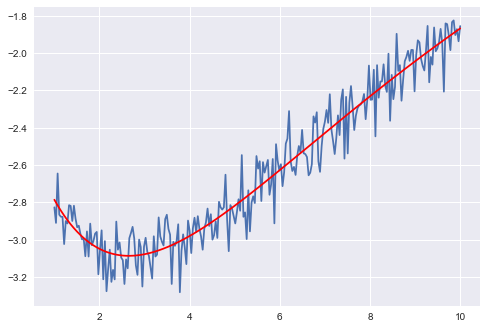

In [10]:
def residual(params, x, y):
    """ Double exponential model.
    """
    v = params.valuesdict()
    model = v['a1']*np.exp(-x/v['t1']) + v['a2']*np.exp(-(x-0.1)/v['t2'])
    
    return (model - y)

# Define params
params = lmfit.Parameters()
params.add('a1', value=4.)
params.add('t1', value=3.)
params.add('a2', value=4.)
params.add('t2', value=3.)

# Fit
mi = lmfit.Minimizer(residual, 
                     params, 
                     fcn_args=(x, y), 
                     nan_policy='omit') # Needed in this case

# First solve with Nelder-Mead (more robust than LM)
res1 = mi.minimize(method='Nelder')

# Then solve with Levenberg-Marquardt using the Nelder-Mead solution 
# as a starting point
res2 = mi.minimize(method='leastsq', params=res1.params)

# Robustly estimate CI
ci = lmfit.conf_interval(mi, res2, sigmas=[0.95,])

# Calculate final result
final = res2.residual + y # Residual was (model - y), so this is an
                          # easy way of getting back to 'model'

# Report
lmfit.report_fit(res2)
print '\n--------------------------\n'
lmfit.printfuncs.report_ci(ci)

# Plot
plt.plot(x, y)
plt.plot(x, final, 'r')
plt.show()

### 4.3. MCMC

We can use the same `lnprob()` function as above for i.i.d. Gaussian errors.

C:\Data\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: overflow encountered in square
C:\Data\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: overflow encountered in exp


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000111D3B38>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000119DD7B8>], dtype=object)

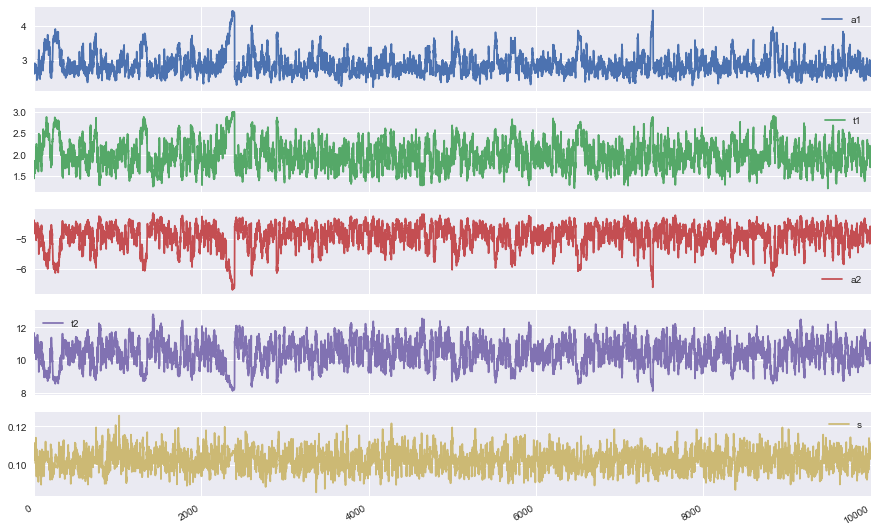

In [11]:
# We want to include sigma as an additional parameter in the MCMC
# Start from 'best fit' params found above
mi.params.add('s', value=1, min=1E-10)

# Run emcee sampler
mi_mcmc = lmfit.Minimizer(lnprob, mi.params, fcn_args=(x, y)) # Use 'best fit' params
result = mi_mcmc.emcee(burn=1000, 
                       steps=2000, 
                       nwalkers=100, 
                       thin=10, 
                       params=mi.params, 
                       float_behavior='posterior') # lnprob returns a float representing log-posterior prob

# Plot traces
result.flatchain.plot(subplots=True, figsize=(15, 10))

Quantiles:
[(0.025, 2.451028088171888), (0.5, 2.7838225912977608), (0.975, 3.6640973761821467)]
Quantiles:
[(0.025, 1.4790476999329567), (0.5, 1.9699046123476673), (0.975, 2.699091200912902)]
Quantiles:
[(0.025, -5.9124818942112087), (0.5, -4.8535647712591583), (0.975, -4.3905432358589511)]
Quantiles:
[(0.025, 8.8549141655746801), (0.5, 10.455808013866406), (0.975, 11.792983120930705)]
Quantiles:
[(0.025, 0.093534572517581835), (0.5, 0.10195139136609892), (0.975, 0.11165098364354424)]


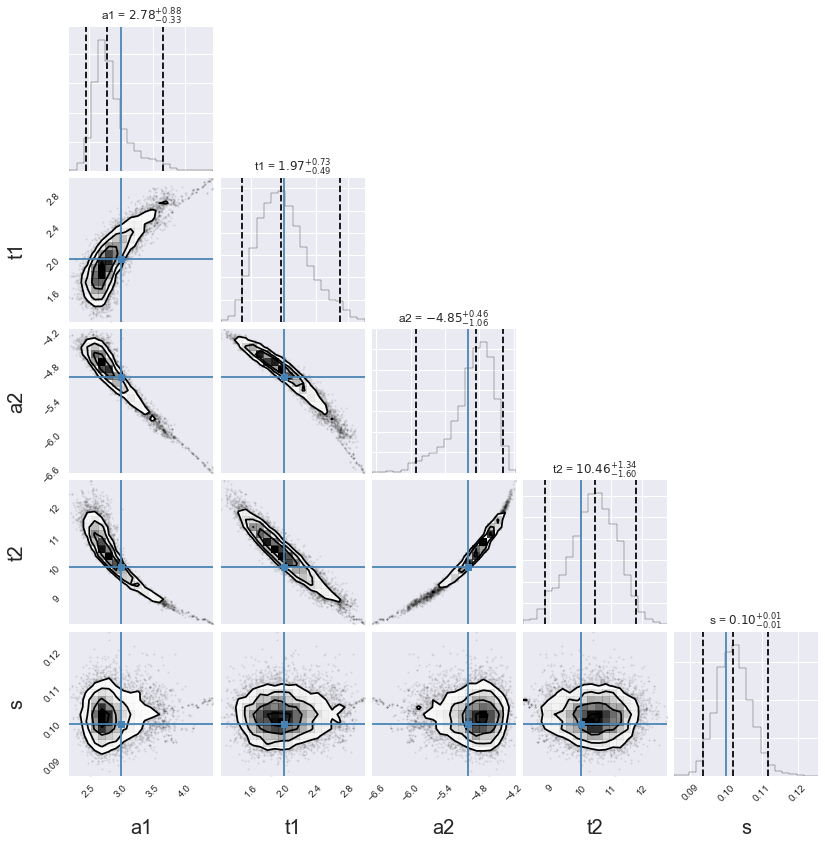

In [12]:
# Triangle plot
tri = corner.corner(result.flatchain,
                    labels=result.var_names,
                    truths=[a1_true, t1_true, a2_true, t2_true, s_true],
                    quantiles=[0.025, 0.5, 0.975],
                    show_titles=True, 
                    title_args={'fontsize': 24},
                    label_kwargs={'fontsize': 20},
                    verbose=True)

Note that emcee is managing to recover the original values, despite very strong (and weirdly shaped) correlation structures in the model.